## Abstract
In this analysis, we plan to apply machine learning techniques to analyze the performance of soccer midfielders, leveraging a comprehensive index based on key performance metrics. Initially, we'll employ a linear model to grasp straightforward relationships between variables, followed by a tree-based model to uncover more intricate patterns within the data. Additionally, we will utilize AutoML, specifically TPOT, to explore various models and identify the most effective one. Through SHAP analysis, we aim to deeply understand how different features influence our models, ensuring a well-rounded interpretation. This structured approach is designed to provide a robust basis for assessing midfielders, ultimately aiding in strategic decision-making.

Our Objective is to Interpret the models.

1. Fitting a linear model and interpret the regression coefficients

2. Fitting a tree-based model and interpret the nodes

3. Using auto ml to find the best model

4. Run SHAP analysis on the models from steps 1, 2, and 3,   interpret the SHAP values and compare them with the other model interpretability methods.



In [1]:
import pandas as pd


attacking_url = 'https://raw.githubusercontent.com/qureshisahil/Assignment-3-Datascience/main/attacking.csv'
attempts_url = 'https://raw.githubusercontent.com/qureshisahil/Assignment-3-Datascience/main/attempts.csv'
defending_url = 'https://raw.githubusercontent.com/qureshisahil/Assignment-3-Datascience/main/defending.csv'
disciplinary_url = 'https://raw.githubusercontent.com/qureshisahil/Assignment-3-Datascience/main/disciplinary.csv'
distributon_url = 'https://raw.githubusercontent.com/qureshisahil/Assignment-3-Datascience/main/distributon.csv'
goalkeeping_url = 'https://raw.githubusercontent.com/qureshisahil/Assignment-3-Datascience/main/goalkeeping.csv'
goals_url = 'https://raw.githubusercontent.com/qureshisahil/Assignment-3-Datascience/main/goals.csv'
key_stats_url = 'https://raw.githubusercontent.com/qureshisahil/Assignment-3-Datascience/main/key_stats.csv'

attacking = pd.read_csv(attacking_url)
attempts = pd.read_csv(attempts_url)
defending = pd.read_csv(defending_url)
disciplinary = pd.read_csv(disciplinary_url)
distributon = pd.read_csv(distributon_url)
goalkeeping = pd.read_csv(goalkeeping_url)
goals = pd.read_csv(goals_url)
key_stats = pd.read_csv(key_stats_url)


Merging the datasets to form a consolidate dataframe

In [2]:
# Merging datasets
consolidated_df = pd.merge(attempts, attacking, on=['player_name', 'club'], how='left', suffixes=('', '_attacking'))
consolidated_df = pd.merge(consolidated_df, defending, on=['player_name', 'club'], how='left', suffixes=('', '_defending'))
consolidated_df = pd.merge(consolidated_df, disciplinary, on=['player_name', 'club'], how='left', suffixes=('', '_disciplinary'))
consolidated_df = pd.merge(consolidated_df, distributon, on=['player_name', 'club'], how='left', suffixes=('', '_distribution'))
consolidated_df = pd.merge(consolidated_df, goalkeeping, on=['player_name', 'club'], how='left', suffixes=('', '_goalkeeping'))
consolidated_df = pd.merge(consolidated_df, goals, on=['player_name', 'club'], how='left', suffixes=('', '_goals'))
consolidated_df = pd.merge(consolidated_df, key_stats, on=['player_name', 'club'], how='left', suffixes=('', '_key_stats'))


# Creating a Midfielder Score
### We'll create a composite score based on a few selected features:

**Assists**: Direct contribution to goals.

**Pass Accuracy**: Indicates quality of playmaking.

**Balls Recovered**: Defensive contribution.

**total_attemps**: Indicates the attemps taken towards the goal.

We'll normalize these metrics to ensure they're on the same scale and sum them up to create a "midfielder score."

In [3]:
from sklearn.preprocessing import MinMaxScaler

# midfielders is filtered from consolidated_df
features = ['total_attempts', 'assists', 'pass_accuracy', 'balls_recoverd']
midfielders = consolidated_df[consolidated_df['position'] == 'Midfielder'].dropna(subset=features)

# Normalizing features
scaler = MinMaxScaler()
midfielders_norm = scaler.fit_transform(midfielders[features])

# Creating the score within the original DataFrame
midfielders['score'] = midfielders_norm.sum(axis=1)


# Fitting a Linear Model
We'll predict the 'score' using the selected features.

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X = midfielders[features]
y = midfielders['score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)


LinearRegression()

In [5]:
linear_model.fit(X_train, y_train)

# After fitting we can print the coefficients
print(f"Coefficients: {linear_model.coef_}")


Coefficients: [0.02777778 0.16666667 0.02932551 0.01639344]


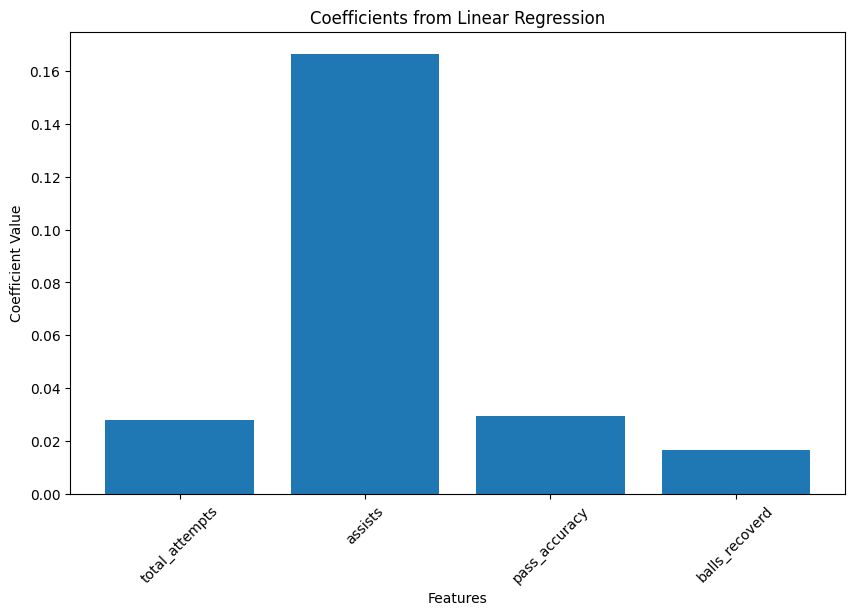

In [6]:
import matplotlib.pyplot as plt

# Plotting the coefficients
plt.figure(figsize=(10, 6))
plt.bar(features, linear_model.coef_)
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.title('Coefficients from Linear Regression')
plt.xticks(rotation=45)
plt.show()


**Total Attempts (0.02777778):** A relatively small positive coefficient suggests that as the total attempts increase, there is a slight increase in the midfielder score.

**Assists (0.16666667):** This is the most significant positive coefficient, indicating that assists are highly influential in increasing the midfielder score. A midfielder who provides more assists will have a higher score.

**Pass Accuracy (0.02932551):** Another positive coefficient, although smaller than that for assists, shows that better pass accuracy contributes to a higher score.

**Balls Recovered (0.01639344):** The smallest positive coefficient among the selected features indicates that while balls recovered do contribute to the score, their impact is less pronounced compared to assists.

 From the chart, we can see that assists are by far the most influential factor in determining the midfielder score, according to the linear model.





 ### We'll use a Random Forest model for its robustness to overfitting and its ability to handle a larger feature space effectively.

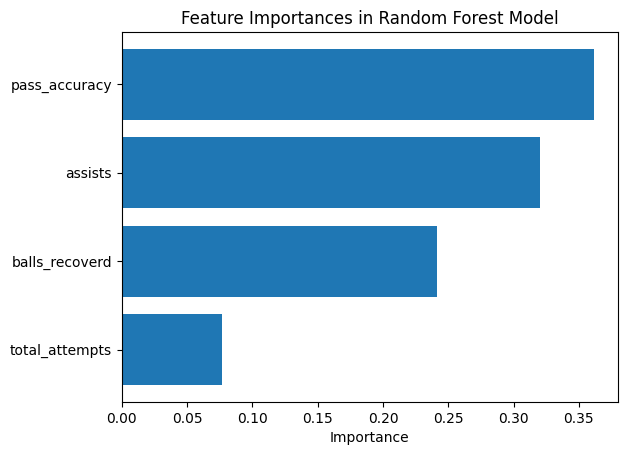

In [7]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# Fit the Random Forest model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Plot the feature importances for better visualization
feature_importances = rf_model.feature_importances_
sorted_idx = rf_model.feature_importances_.argsort()

plt.barh([features[i] for i in sorted_idx], rf_model.feature_importances_[sorted_idx])
plt.xlabel('Importance')
plt.title('Feature Importances in Random Forest Model')
plt.show()




**Pass Accuracy:** This is the most important feature according to the model, indicating that a player's accuracy in passing contributes significantly to their overall midfielder score.

**Assists:** Following closely, assists are also highly important, showing that the ability to create goal-scoring opportunities is crucial.

**Balls Recovered:** This has moderate importance, suggesting that
defensive actions contributing to ball possession are valued.

**Total Attempts:** Surprisingly, this feature has the least importance, which could indicate that the quantity of attempts is not as critical as the quality (e.g., pass accuracy and assists) for the model's prediction of a midfielder's performance.



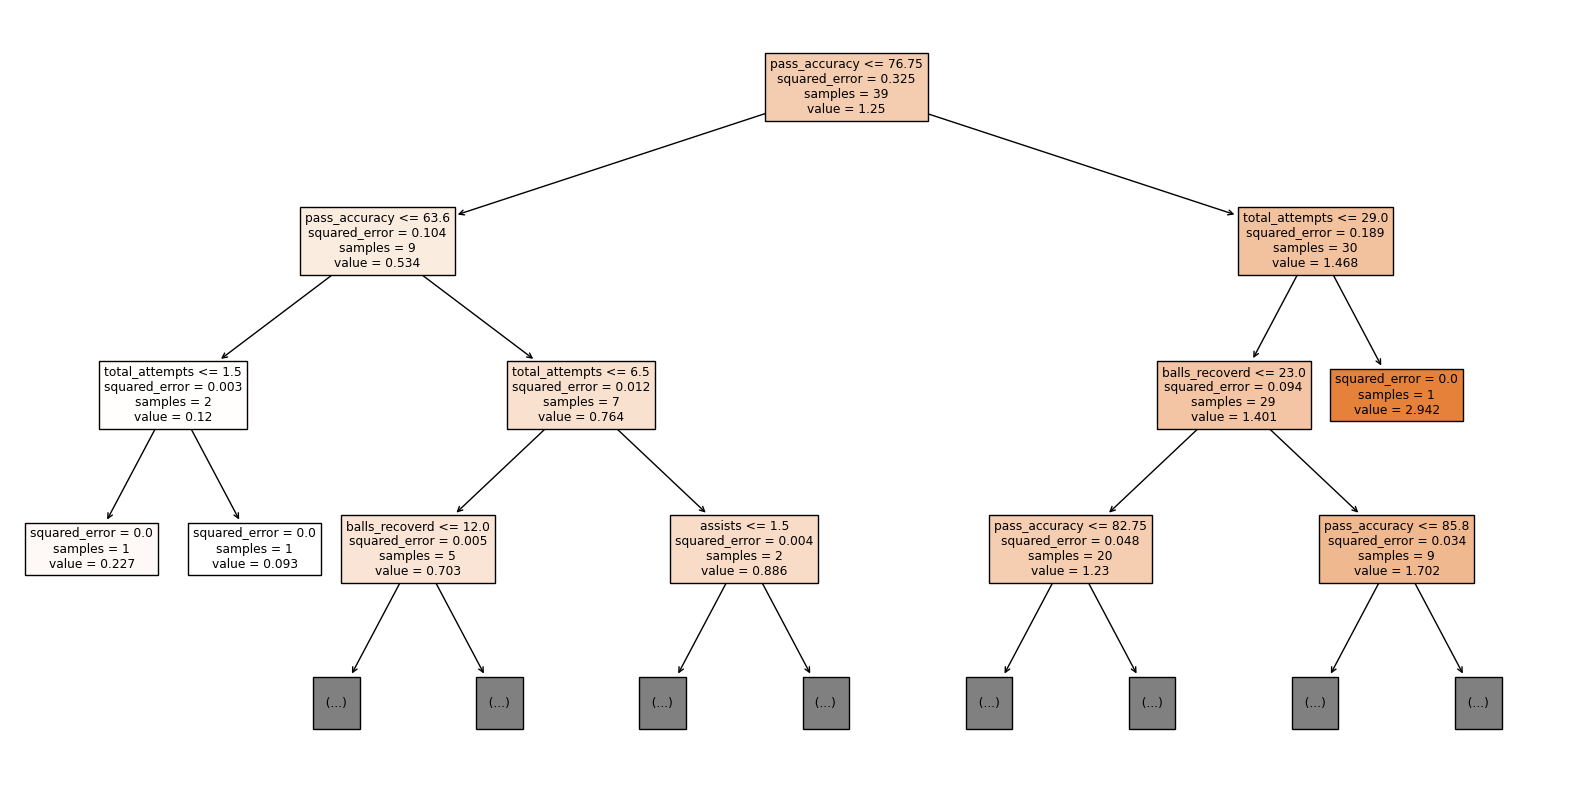

In [8]:
from sklearn.tree import plot_tree

# Extract a single tree from the Random Forest
single_tree = rf_model.estimators_[0]

plt.figure(figsize=(20,10))
plot_tree(single_tree, feature_names=features, filled=True, max_depth=3)
plt.show()


Each node represents a condition on a single feature that splits the data to maximize the difference in the midfielder score between the two paths.

**pass_accuracy:** The root node suggests that pass accuracy is the most significant feature for splitting the data initially. Players with a pass accuracy less than or equal to 76.75 are split towards the left, and those above go right.

**total_attempts and balls_recovered:** These features are used in subsequent splits, indicating their importance in further segmenting the players.

**squared_error:** This value indicates the mean squared error of the samples that fall into that node. A lower squared error represents a node with more confident predictions.

**samples:** The number of samples in that node.

**value:** The average score of all samples in that node.

*The darker orange color indicates higher values, and the lighter color indicates lower values. The first split of pass accuracy and further splits show which features and thresholds most significantly separate players into different predicted score groups.*


### Auto ML
To use AutoML to find the best model, we have used a library called TPOT. TPOT automates the process of selecting the best machine learning pipeline that preprocesses the data and selects the model.

In [ ]:
pip install tpot


In [9]:
from tpot import TPOTRegressor

# Initialize TPOT regressor
tpot_regressor = TPOTRegressor(generations=5, population_size=20, verbosity=2, scoring='neg_mean_squared_error', random_state=42)

# Fit the TPOT regressor to the training data
tpot_regressor.fit(X_train, y_train)

# Once fitting is done, you can review the best pipeline
print("Best pipeline:", tpot_regressor.fitted_pipeline_)

# Export the pipeline as a Python script file
tpot_regressor.export('best_pipeline.py')


Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -3.005138256684551e-07

Generation 2 - Current best internal CV score: -3.005138256684551e-07

Generation 3 - Current best internal CV score: -2.4674594121264996e-08

Generation 4 - Current best internal CV score: -2.4674594121264996e-08

Generation 5 - Current best internal CV score: -2.4674594121264996e-08

Best pipeline: LinearSVR(MaxAbsScaler(input_matrix), C=5.0, dual=True, epsilon=0.0001, loss=epsilon_insensitive, tol=1e-05)
Best pipeline: Pipeline(steps=[('maxabsscaler', MaxAbsScaler()),
                ('linearsvr',
                 LinearSVR(C=5.0, dual=True, epsilon=0.0001, random_state=42,
                           tol=1e-05))])


TPOT has identified LinearSVR with a MaxAbsScaler preprocessing step as the best pipeline for our data. The reported internal cross-validation score is very close to zero, which suggests that the model is fitting the data quite well

The parameters chosen for LinearSVR are:

C: 5.0 (the regularization parameter)

Epsilon: 0.0001 (specifies the epsilon-tube within which no penalty is associated with predictions)

Loss: Epsilon-insensitive (uses a linear loss function)

The MaxAbsScaler preprocessing scales each feature by its maximum absolute value to transform it into the range [-1, 1], which can be particularly useful for sparse data.

In [11]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 5.7 MB/s eta 0:00:00


  0%|          | 0/15 [00:00<?, ?it/s]

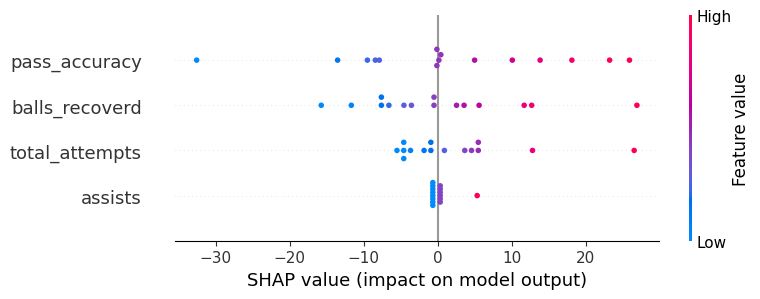

In [17]:
import shap

# Since TPOT has chosen a pipeline, we'll access the trained LinearSVR model within the pipeline
svr_model = tpot_regressor.fitted_pipeline_.steps[-1][1]

# We will Use KernelExplainer for the LinearSVR model
explainer = shap.KernelExplainer(svr_model.predict, X_train)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Plot the SHAP values
shap.summary_plot(shap_values, X_test, feature_names=features)


## Linear Model SHAP Analysis


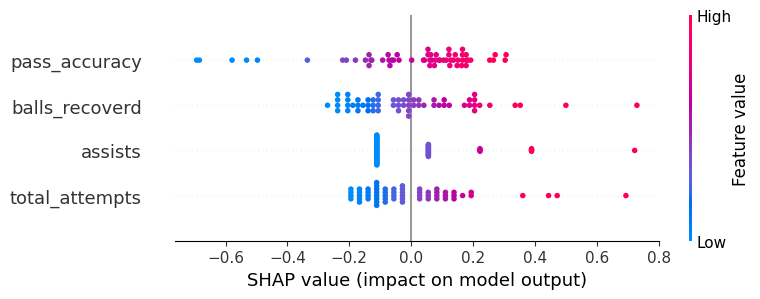

In [18]:
# For the linear model, we use the LinearExplainer
explainer_linear = shap.Explainer(linear_model.predict, X_train)
shap_values_linear = explainer_linear(X_train)

# Plot the SHAP values for the linear model
shap.summary_plot(shap_values_linear, X_train, feature_names=features)

#### **Linear Model (First Plot):** The SHAP values for the linear model indicate that assists and pass accuracy are the most influential features, with high assists particularly increasing the predicted outcome significantly. This aligns with expectations as linear models assign a consistent impact per unit change in feature value.

## Tree-Based Model SHAP Analysis

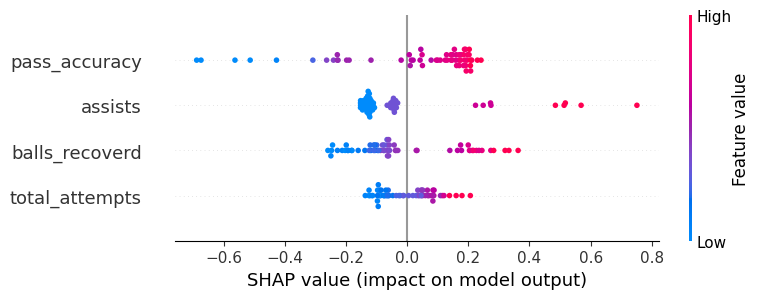

In [19]:
# For the tree-based model, we use the TreeExplainer
explainer_rf = shap.TreeExplainer(rf_model)
shap_values_rf = explainer_rf.shap_values(X_train)

# Plot the SHAP values for the tree-based model
shap.summary_plot(shap_values_rf, X_train, feature_names=features)


#### **Tree-Based Model (Second Plot):** For the tree-based model, the SHAP values show a different pattern of impact. Pass accuracy and balls recovered appear to have the most variability in impact, with pass accuracy showing both high positive and negative effects. This suggests non-linear relationships and interactions between features are being captured.

## AutoML Model SHAP Analysis

  0%|          | 0/60 [00:00<?, ?it/s]

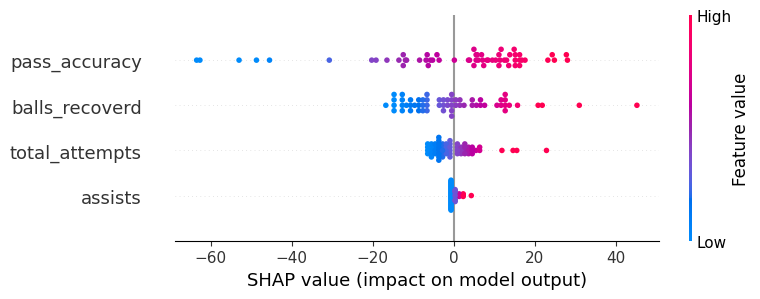

In [21]:
# TPOT's best model is a LinearSVR
svr_model = tpot_regressor.fitted_pipeline_.steps[-1][1]

# We Use KernelExplainer for the LinearSVR model
explainer_svr = shap.KernelExplainer(svr_model.predict, X_train)
shap_values_svr = explainer_svr.shap_values(X_train)

# Plot the SHAP values for the TPOT best model
shap.summary_plot(shap_values_svr, X_train, feature_names=features)


#### **Best Model from AutoML (Third Plot):** The AutoML-chosen model (LinearSVR) presents an interesting picture. It shows assists having a considerable spread in impact on the model's prediction, which could be due to the model capturing more complex relationships than a simple linear regression.

In [22]:
from sklearn.metrics import mean_squared_error, r2_score

# Predictions
y_pred_linear = linear_model.predict(X_test)

# Model Accuracy
mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)
print("Linear Model")
print(f"Predictions: {y_pred_linear}")
print(f"MSE: {mse_linear}")
print(f"R^2: {r2_linear}")


Linear Model
Predictions: [1.5896231  1.2230475  1.70103868 2.28166114 0.92004391 0.67312202
 1.19663852 1.24146275 1.1362341  1.46178603 1.25987533 0.98437709
 1.12549477 2.17488876 1.74714223]
MSE: 1.3155899054779582e-30
R^2: 1.0


In [23]:
# Predictions
y_pred_rf = rf_model.predict(X_test)

# Model Accuracy
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print("\nRandom Forest Model")
print(f"Predictions: {y_pred_rf}")
print(f"MSE: {mse_rf}")
print(f"R^2: {r2_rf}")



Random Forest Model
Predictions: [1.32575469 1.31742637 1.4150778  1.49262961 1.06270798 0.79399659
 0.97951021 1.24506122 1.21380157 1.51752163 1.25745434 1.06379635
 1.06439407 1.85632134 1.48610586]
MSE: 0.0702529699462204
R^2: 0.6259345277121778


In [24]:
# TPOT uses the best pipeline it discovered
# We make predictions using the fitted pipeline
y_pred_tp = tpot_regressor.predict(X_test)

# Model Accuracy
mse_tp = mean_squared_error(y_test, y_pred_tp)
r2_tp = r2_score(y_test, y_pred_tp)
print("\nAutoML (TPOT) Model")
print(f"Predictions: {y_pred_tp}")
print(f"MSE: {mse_tp}")
print(f"R^2: {r2_tp}")



AutoML (TPOT) Model
Predictions: [1.58958936 1.22307623 1.70093094 2.28159721 0.92004967 0.67310526
 1.1966894  1.2414338  1.13622717 1.46172861 1.25980156 0.98434605
 1.12567579 2.17500215 1.7470838 ]
MSE: 5.345834849189222e-09
R^2: 0.9999999715358334


In [26]:
# Add predictions to the midfielders DataFrame
midfielders['predicted_score_linear'] = linear_model.predict(midfielders[features])

# Get the top 10 midfielders
top_midfielders_linear = midfielders.nlargest(10, 'predicted_score_linear')[['player_name', 'club', 'predicted_score_linear']]

print(top_midfielders_linear)

         player_name         club  predicted_score_linear
3               Sané       Bayern                2.942115
104           Capoue   Villarreal                2.593190
40            Modrić  Real Madrid                2.431276
2             Mahrez    Man. City                2.281661
64   Bruno Fernandes  Man. United                2.174889
16         De Bruyne    Man. City                2.038894
195           Parejo   Villarreal                2.000860
50        Bellingham     Dortmund                1.902953
132   Bernardo Silva    Man. City                1.893443
231         Jorginho      Chelsea                1.853625


In [28]:
# Add predictions to the midfielders DataFrame
midfielders['predicted_score_rf'] = rf_model.predict(midfielders[features])

# Get the top 10 midfielders
top_midfielders_rf = midfielders.nlargest(10, 'predicted_score_rf')[['player_name', 'club', 'predicted_score_rf']]

print(top_midfielders_rf)

         player_name         club  predicted_score_rf
3               Sané       Bayern            2.586690
104           Capoue   Villarreal            2.468363
40            Modrić  Real Madrid            2.368482
50        Bellingham     Dortmund            1.975851
195           Parejo   Villarreal            1.955123
16         De Bruyne    Man. City            1.905794
132   Bernardo Silva    Man. City            1.895201
64   Bruno Fernandes  Man. United            1.856321
231         Jorginho      Chelsea            1.774595
59         Henderson    Liverpool            1.724038


In [29]:
# Add predictions to the midfielders DataFrame
midfielders['predicted_score_tp'] = tpot_regressor.predict(midfielders[features])

# Get the top 10 midfielders
top_midfielders_tp = midfielders.nlargest(10, 'predicted_score_tp')[['player_name', 'club', 'predicted_score_tp']]

print (top_midfielders_tp)


         player_name         club  predicted_score_tp
3               Sané       Bayern            2.942116
104           Capoue   Villarreal            2.593290
40            Modrić  Real Madrid            2.431282
2             Mahrez    Man. City            2.281597
64   Bruno Fernandes  Man. United            2.175002
16         De Bruyne    Man. City            2.038880
195           Parejo   Villarreal            2.000938
50        Bellingham     Dortmund            1.902932
132   Bernardo Silva    Man. City            1.893386
231         Jorginho      Chelsea            1.853591


## Conclusion
In our study, we used different models to understand what makes a good midfielder in soccer. The linear model showed us that assists are really important for a midfielder's performance. When we looked at the tree-based model, we found that not just assists, but also how accurately players pass the ball and recover it matters. AutoML helped us find the best model, and using SHAP analysis, we got a detailed view of how each feature, like assists and pass accuracy, affects a player's score. This helped us see that while assists are crucial, other skills are also vital for midfielders. This analysis can help teams make better decisions when choosing or training midfielders.

### MIT License

Copyright (c) 2024 qureshisahil

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
